# XGBoost Model Evaluation

This notebook loads the preprocessed data and the serialized XGBoost model as a last check before preparing the model for production. 

In addition we make a quick feature analysis that may be extended if necessary.

In [1]:
import json
import joblib

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import utils # Import the new utils module

In [2]:
df = utils.load_preprocessed_data('data/preprocessed_data2.parquet')

# Separate train/test and features/target using utility function
X_train_scaled, y_train, X_test_scaled, y_test = utils.split_data_features_target(df)

# Convert target variables using utility function
y_train = utils.convert_target_variable(y_train)
y_test = utils.convert_target_variable(y_test)

Loading preprocessed data from data/preprocessed_data2.parquet...
Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 3700 entries, 0 to 739
Data columns (total 55 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BIB           3700 non-null   float64
 1   FAN           3700 non-null   float64
 2   LUK           3700 non-null   float64
 3   NUS           3700 non-null   float64
 4   SIS           3700 non-null   float64
 5   UIN           3700 non-null   float64
 6   WET           3700 non-null   float64
 7   COD_iii       3700 non-null   float64
 8   COD_rrr       3700 non-null   float64
 9   COD_uuu       3700 non-null   float64
 10  ERG_aaa       3700 non-null   float64
 11  ERG_missing   3700 non-null   float64
 12  ERG_nnn       3700 non-null   float64
 13  ERG_www       3700 non-null   float64
 14  GJAH_ii       3700 non-null   float64
 15  GJAH_iii      3700 non-null   float64
 16  GJAH_missing  3700 non-null 

In [3]:
with open('data/calibrated_xgb_isotonic_model_metadata.json', 'r') as f:
    loaded_metadata = json.load(f)
    
loaded_model_path = loaded_metadata['model_filepath']
loaded_optimal_threshold = loaded_metadata['optimal_threshold_f1_class0']

xgb_clf = joblib.load(loaded_model_path)

In [4]:
# Make Predictions on the test set
y_new_proba = xgb_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = (y_new_proba >= loaded_optimal_threshold).astype(int)


--- XGBoost Evaluation ---
Accuracy: 0.9973

Classification Report:
              precision    recall  f1-score   support

 Class n (0)       1.00      0.96      0.98        55
 Class y (1)       1.00      1.00      1.00       685

    accuracy                           1.00       740
   macro avg       1.00      0.98      0.99       740
weighted avg       1.00      1.00      1.00       740


Confusion Matrix:
[[ 53   2]
 [  0 685]]


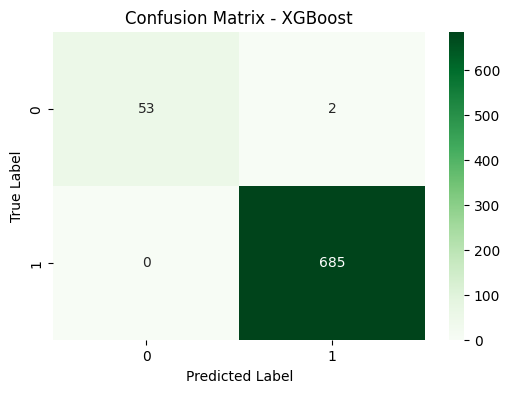


ROC AUC Score: 0.9874


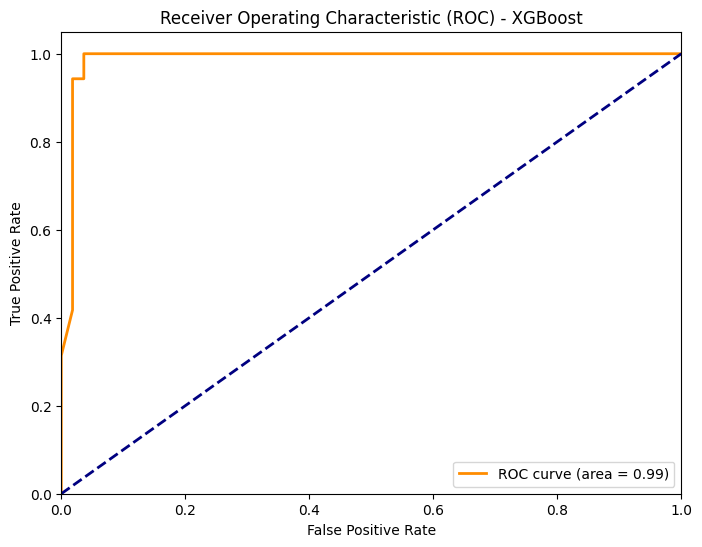

In [5]:
# Evaluate the XGBoost model using the utility function
utils.evaluate_model_performance(y_test, y_pred_xgb, X_test_scaled, xgb_clf, "XGBoost")

## Feature Importance Analysis

This section visualizes the importance of each feature in the XGBoost model.


--- Feature Importance Analysis ---
Top 10 Feature Importances:
    feature  importance
46    VOL_f    0.298946
8   COD_rrr    0.270374
6       WET    0.048912
18   MYR_ee    0.036134
31  MYR_zzz    0.035779
35  PKD_jjj    0.031047
28  MYR_sss    0.027626
2       LUK    0.022456
19  MYR_eee    0.021148
48  KAT_ccc    0.017571




/var/folders/vn/k5xzhc610rsbtw99_schb6d80000gn/T/ipykernel_71761/1991055342.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(num_features_to_plot), palette='viridis')


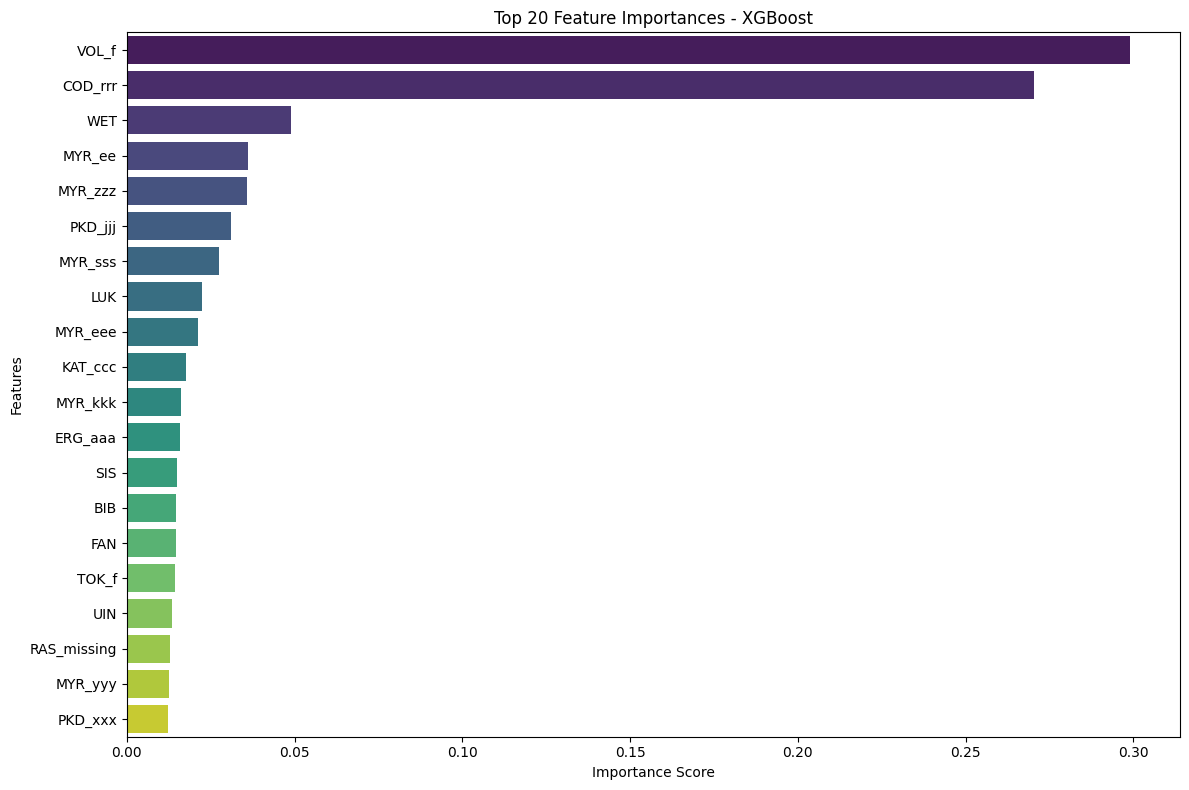

In [6]:

# Get feature importances from the trained XGBoost model
importances = xgb_clf.calibrated_classifiers_[0].estimator.feature_importances_
feature_names = X_train_scaled.columns # X_train_scaled has the feature names

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\n--- Feature Importance Analysis ---")
print("Top 10 Feature Importances:")
print(feature_importance_df.head(10))
print("\n") # Add a newline for better separation in output

# Plotting the feature importances (e.g., top 20 features)
plt.figure(figsize=(12, 8)) # Adjust figure size as needed
num_features_to_plot = min(len(feature_importance_df), 20) # Plot top 20 or fewer if not available
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(num_features_to_plot), palette='viridis')
plt.title(f'Top {num_features_to_plot} Feature Importances - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()